In [1]:
# Copyright 2024 Keysight Technologies Inc.

In [2]:
import numpy as np
import trueq as tq
import trueq.simulation as tqs

In [3]:
p = 0.01
s1 = tq.math.Superop.from_kraus(
    [np.sqrt(1 - p) * np.eye(2), np.sqrt(p) * tq.Gate.x.mat]
)

p = 0.02
s2 = tq.math.Superop.from_kraus(
    [np.sqrt(1 - p) * np.eye(4), np.sqrt(p) * tq.math.random_unitary(4)]
)


class ExampleNoise(tqs.NoiseSource):
    def __init__(self, match=None):
        # this simulator hardcodes the subsystem dimension to 2
        super().__init__(dim=2, match=match)

    def make_circuit_cache(self, circuit):
        # this return will be made available to apply() as circuit_cache for every
        # cycle in the circuit
        return set(circuit.labels)

    def apply(self, cycle_wrappers, backend, circuit_cache):
        # in this method we ask the backend to process certain operations

        used_labels = set()
        # loop through the gates in the cycle and ask the backend to process them
        # note that we must set noise_only=False since we are simulating each gate
        for labels, gate in self.match.iter_gates(cycle_wrappers, noise_only=False):
            used_labels.update(labels)
            # first do ideal simulation of this gate
            backend.process_gate(labels, gate)

            # now add some superoperator noise to each qubit the gate acts on
            if len(labels) == 1:
                backend.process_superop(labels, s1)
            elif len(labels) == 2:
                backend.process_superop(labels, s2)

        # apply a 20 degree Z rotation to every qubit without a gate in this cycle
        for label in circuit_cache.difference(used_labels):
            backend.process_gate((label,), tq.Gate.rp("Z", 20))

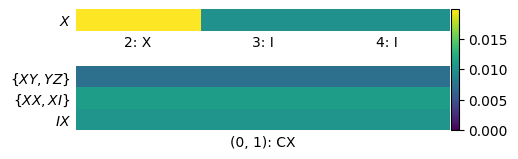

In [4]:
sim = tq.Simulator().append_noise_source(ExampleNoise())

cycle = {(0, 1): tq.Gate.cnot, 2: tq.Gate.x}
fit = sim.predict_knr(cycle, twirl=tq.Twirl("P", range(5)))
fit.plot.knr_heatmap()